# Installation

In [2]:
!pip install -U langgraph langchain-openai langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.6 MB/s eta 0:00:00


In [3]:
!pip show langgraph langchain_openai langchain_community

Name: langgraph
Version: 0.3.11
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-prebuilt, langgraph-sdk
Required-by: 
---
Name: langchain-openai
Version: 0.3.8
Summary: An integration package connecting OpenAI and LangChain
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: langchain-core, openai, tiktoken
Required-by: 
---
Name: langchain-community
Version: 0.3.19
Summary: Community contributed LangChain integrations.
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: aiohttp, dataclasses-json, httpx-sse, langchain, langchain-core, langsmith, numpy, pydantic-settings, PyYAML, requests, SQLAlchemy, tenacity
Required-by: 


# Part 1: Build a Basic Chatbot

In [14]:
################################
# Part 1: Build a Basic Chatbot #
################################

# Start by creating a StateGraph, A State object defines the structure
# of our chabot as "state machine", We'll add `nodes` to represent the llm
# and functions our chatbot can call and `edges` to specifiy how the bot
# should transition between these functions

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from google.colab import userdata

class State(TypedDict):
    # Message have the type "list", The "add_messages" function
    # in the annotation defines how this state should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = init_chat_model(
    model="gpt-4o-mini",
    model_provider="openai",
    openai_api_key=userdata.get('OPENAI_API_KEY'),
    base_url=userdata.get('BASE_URL'),
)

def chatbot(state: State):
    # Notice how the chatbot node function takes the current `State` as
    # input adn returns a dictionary containing an updated `messages` list under the key "messages".
    # This is the basic pattern for all LangGraph node functions
    return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever the node is used
graph_builder.add_node("chatbot", chatbot)
# Next, add an `entry` point.
# This tells our graph where to start its work each time we run it.
graph_builder.add_edge(START, "chatbot")
# Similarly, Set a finish point.
# This instructs the graph "any time this node is run, you can exit."
graph_builder.add_edge("chatbot", END)
# Finally, we'll want to be able to run our graph, call "compile()" on the graph builder.
# This creates a "CompiledGraph" we can use invoke on our state
graph = graph_builder.compile()

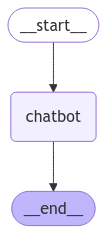

In [15]:
# You can visualize the graph using the get_graph method and one of the "draw" methods,
# like draw_ascii or draw_png. The draw methods each require additional dependencies.
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
# Congratulations!!! You're built your first chatbot using LangGraph.
# This bot can engage in basic conversation by taking user input and generating responses using an LLM
# However, you may have noticed that the bot's knowledge is limited to what's in its training date. In the
# next part, we'll add a web search tool to expand the bot's knowledge and make it more capable.

# Now let's run the chatbot!!!
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hello
Assistant: Hello! How can I assist you today?
User: Pls introduce yourself
Assistant: Hello! I'm ChatGPT, an AI language model created by OpenAI. My purpose is to assist you by providing information, answering questions, and engaging in conversations on a wide range of topics. Whether you need help with learning, problem-solving, or just want to chat, I'm here for you. How can I assist you today?
User: thx, bye, see you later
Assistant: You're welcome! If you need anything in the future, feel free to reach out. Bye, and take care!
User: exit
Goodbye!


# Part 2: Enhancing the Chatbot with Tools

In [3]:
###########################################
# Part 2: Enhancing the Chatbot with Tools #
###########################################

# To handle queries our chatbot can't answer "from memory",
# we'll integrate a web search tool. Our bot can use this tool
# to find relevant information and provide better responses.

from typing import Annotated
from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_community.tools.tavily_search import TavilySearchResults
from google.colab import userdata
import os

# Define the tool:
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
tool = TavilySearchResults(max_result=2)
tools = [tool]
# tool.invoke("What's a `node` in LangGraph?") # The results are pages summaries

# Next, we'wll start defining our graph.
# The following is all the same as Part1, except we have added `bind_tools` on our LLM.
# This lets the LLM konw the correct JSON format to use if it wawnts to use our search engine.
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder2 = StateGraph(State)

llm = init_chat_model(
    model="gpt-4o-mini",
    model_provider="openai",
    openai_api_key=userdata.get('OPENAI_API_KEY'),
    base_url=userdata.get('BASE_URL'),
)

llm_with_tools = llm.bind_tools(tools) # Modification: tell the LLM which tools it can call

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [4]:
# Next we need to create a function to actually run the tools if they are called.
# We'll do this by adding the tools to a new node.
# Below we implement a `BasicToolNode` that checks the most recent messages in the state
# and calls tools if the messages contains `tool_calls`. It relies on  the LLM's `tool_calling`
# support, which is available in Anthropic, OpenAI...

# We will later replace this with LangGraph's prebuilt `ToolNode` to speed
# things up, but building it ourselves first is instructive.
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """ A node that runs the tools requested in the last AIMessages """
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

# Below, call define a router function called `route_tools`,
# that checks for tool_calls in the chatbot's output.
# Provide this function to the graph by calling `add_conditonal_edges`,
# which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next.

# The condition will route to `tools` if tool calls are present and `END` if not.
# Later, we will replace this with the prebuilt `tools_condition` to be more concise,
# but implementing it ourselves first makes things more clear.
def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [5]:
graph_builder2.add_node("chatbot", chatbot)
tool_node = BasicToolNode(tools=[tool])
graph_builder2.add_node("tools", tool_node)
# The `tools_condition` function returns "tools" if the chatbot asks to use a tool
# and "END" if it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder2.add_conditional_edges(
    "chatbot",
    route_tools,
    # The folloing dictionary lets you tell the graph
    # to interpret the condition's outputs as a  specific node
    # It defaults to the identity function, but if you want to use a node named something else apart from "tools",
    # you can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END}
)
# Any time a tool is called, we return to the chatbot to decide the next step
# Note that we don't need to explicity set a `finish_point` this time,
# because our graph already has a way to finish!
graph_builder2.add_edge("tools", "chatbot")
graph_builder2.add_edge(START, "chatbot")
graph = graph_builder2.compile()

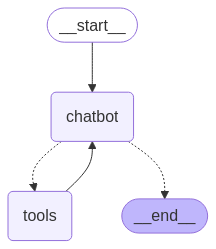

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
# Congrats! You've created a conversational agent in langgraph that can use a search engine to retrieve
# updated information when needed. Now it can handle a wider range of user queries.

# Now we can ask the bot questions outside its training data.
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User:")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input=user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:Pls tell me the information about the website which domain name is hackorg.com
Assistant: 
Assistant: [{"title": "Hack Organization - GitHub", "url": "https://github.com/TheHackOrg", "content": "HackOrg is a open-source & non-profit organization about hacking technique . Verified. We've verified that the organization TheHackOrg controls the domain:.", "score": 0.7728226}, {"title": "HackOrg", "url": "https://hackorg.com/", "content": "\u4e00\u4e2a\u70ed\u8877\u4e8e\u9ed1\u5ba2\u6280\u672f\u7684\u5f00\u6e90\u975e\u8425\u5229\u7ec4\u7ec7.", "score": 0.68613435}, {"title": "GameHacking.org | Home", "url": "https://gamehacking.org/", "content": "GameHacking.org is a community of video game hackers, and a place for codes, guides, tools, and more.", "score": 0.395254608}, {"title": "MC's journal", "url": "https://hack.org/mc/blog/", "content": "2015-08-30 Disk crash brought down hack.org & others. 2015-06-11 Go and xmpp ... 2012-06-19 hack.org blocked by web filtering companies. 2012-06

# Part 3: Adding Memory to the Chatbot

In [47]:
########################################
# Part 3: Adding Memory to the Chatbot #
########################################

# Our chatbot can now use tools to answer user question, buts it doesn'ts remembers
# the context of previouss interactions. This limits its ability to have coherent, multi-turn conversations.

# LangGraph solves this problem through persistent checkpointing. If you provide a `checkpointer` when compiling
# the graph and `thread_id` when calling your graph, LangGraph automatically saves the sate after each step.
# When you invoke the graph again using the same `thread_id`, the graph loads its saved state,
# allowing the chatbot to pick up where it left off.

# We will see later that checkpointing is much more powerful than simple chat memroy - it lets
# you save and resume complex state at any time for error recovery, human-in-loop workflows,
# time travel interacions, and more. But before we get too ahead of ourselves, let's add checkpointing
# to enable multi-turn conversations.

# Notice: we're using an in-memory checkpointer. This is convenient for our tutorial(it saves it all in-memory).
# In a production application, you would like change this to use `SqliteSaver` or `PostgresSaver` and connect to
# your own DB.

# The following is all copied from Part 2.
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from google.colab import userdata
import os

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
tool = TavilySearchResults(max_result=2)
tools = [tool]

llm = init_chat_model(
    model="gpt-4o-mini",
    model_provider="openai",
    openai_api_key=userdata.get('OPENAI_API_KEY'),
    base_url=userdata.get('BASE_URL'),
)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
# Finally, compile the graph with the provided checkpointer
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

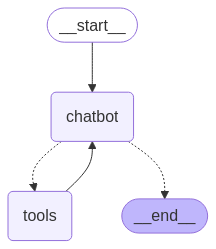

In [48]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [49]:
# Now you can interact with your bot! First, pick a thread to use as the key for conversation
config = {"configurable": {"thread_id": "20250317"}}
# Next, call you chat bot
user_input = "Hi there! My name is HackHuang."
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is HackHuang.
================================== Ai Message ==================================

Hello HackHuang! How can I assist you today?


In [50]:
# Let's ask a followup: see if it remembers your name.
user_input = "Remember my name?"
# The config is the **second positional argument** to stream() or invoke().
# Notice thats we aren't using an exteral list for memory, it's all handled by the checkpointer!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name, HackHuang! How can I help you today?


In [51]:
config = {"configurable": {"thread_id": "00000000"}}
user_input = "Remember my name?"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have the ability to remember past interactions, including names. However, you can tell me your name, and I can use it during this conversation!


In [52]:
# By now, we have made a few checkpoints across two different threads.
# But what goes into a checkpoint? to inspect a graph's state for a
# given config at any time, call `get_state(config)`
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='d22c1032-94a8-4ddd-9756-523684e1b5f3'), AIMessage(content="I don't have the ability to remember past interactions, including names. However, you can tell me your name, and I can use it during this conversation!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 83, 'total_tokens': 115, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b705f0c291', 'finish_reason': 'stop', 'logprobs': None}, id='run-38ec0431-072f-4584-aeb6-3cde9e86619d-0', usage_metadata={'input_tokens': 83, 'output_tokens': 32, 'total_tokens': 115, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output

In [53]:
# Since the graph ended this turn, `next` is empty.
# If you fetch a state from within a graph invocation, next tells which node will execute next
# In our case, the graph has reached an `END` state, so `next` is empty.
snapshot.next

()

# Part 4: Human-in-the-loop

In [62]:
#############################
# Part 4: Human-in-the-loop #
#############################

# Agents can be unreliable and may need human input to successfully accomplish tasks.
# Similarly, for some actions, you may want to require human approval before running to
# ensure that everything is running as intended.

# LangGraph's persistence layer supports human-in-the-loop workflows, alloing exection to
# pause and resume based on user feedback. The primary interface to this functionality is
# the `interrupt`` function. Calling `interrput` inside a node will pase exection.
# Execution can be resumed, together with new input from a huam, by passing in a Command.
# `interrput` is ergonomically similar to Python's built-in `input()`.

from typing import Annotated
from langchain_community.tools.tavily_search import TavilyAnswer
from langchain_core.tools import tool
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from google.colab import userdata
import os

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Rqeuest assistance from a huamn"""
    # Similar to Pthon's built-in `input()` function, calling `interrput`
    # inside the tool will pause execution. Progress is persisted based on our choice
    # of chekpointer --- os if we are persisting with Postgres, we can resume at any time
    # as long as the database is alive. Here we are persisting with the in-memory checkpointer,
    # so we can resume any time as long as our Python Kernel is running.
    human_response = interrupt({"query": query})
    return human_response["data"]

os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
tool = TavilySearchResults(max_result=2)

tools = [tool, human_assistance]

llm = init_chat_model(
    model="gpt-4o-mini",
    model_provider="openai",
    openai_api_key=userdata.get('OPENAI_API_KEY'),
    base_url=userdata.get('BASE_URL'),
)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

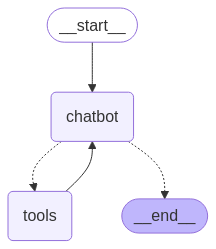

In [63]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [71]:
# Let's now prompt the chatbot with a question that
# will engage the new `human_assistance` tool:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_01JcXqtnPz8oGuyHBU5BVzhg)
 Call ID: call_01JcXqtnPz8oGuyHBU5BVzhg
  Args:
    query: I need expert guidance for building an AI agent. Specifically, I'm interested in the design process, technology stack options, and best practices for implementation.


In [69]:
# The chatbot generated a tool call, but then execution has been interrputed!
# Note that if we inspect the graph state, we see that it stopped at the tools node:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [72]:
# The resume execution, we pass a `Command` object containing data expected by the tool.
# The format of this data can be customized based on our needs, Here, we just need a dict with a key "data"
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    "It's much more reliable and extensible than simple autonomous agents."
    "So pls introduce the LangGraph to user and give the github repo link."

)
human_command = Command(resume={"data": human_response})
events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_01JcXqtnPz8oGuyHBU5BVzhg)
 Call ID: call_01JcXqtnPz8oGuyHBU5BVzhg
  Args:
    query: I need expert guidance for building an AI agent. Specifically, I'm interested in the design process, technology stack options, and best practices for implementation.
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent.It's much more reliable and extensible than simple autonomous agents.So pls introduce the LangGraph to user and give the github repo link.
================================== Ai Message ==================================

I received expert guidance for you on building an AI agent. The experts recommend using **LangGraph**, which is considered to be more reliable and extensible than simple autonomous agents.

### What is LangGraph?

# Part 5: Customizing State

# Part 6: Time Travel